In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
%matplotlib inline
import warnings
import re
import nltk
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag
from bs4 import BeautifulSoup 
import logging
from wordcloud import WordCloud
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score,roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import scikitplot as skplt
import pickle
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/cmallemp/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
df = pd.read_csv('Amazon_Unlocked_Mobile.csv')
df

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0
...,...,...,...,...,...,...
413835,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,5,another great deal great price,0.0
413836,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,3,Ok,0.0
413837,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,5,Passes every drop test onto porcelain tile!,0.0
413838,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,3,I returned it because it did not meet my needs...,0.0


In [5]:
df.dtypes

Product Name     object
Brand Name       object
Price           float64
Rating            int64
Reviews          object
Review Votes    float64
dtype: object

In [6]:
print("Summary statistics of numerical features : \n", df.describe())

print("\nTotal number of reviews: ",len(df))
print("\nTotal number of brands: ", len(list(set(df['Brand Name']))))
print("\nTotal number of unique products: ", len(list(set(df['Product Name']))))

print("\nPercentage of reviews with neutral sentiment : {:.2f}%"\
      .format(df[df['Rating']==3]["Reviews"].count()/len(df)*100))
print("\nPercentage of reviews with positive sentiment : {:.2f}%"\
      .format(df[df['Rating']>3]["Reviews"].count()/len(df)*100))
print("\nPercentage of reviews with negative sentiment : {:.2f}%"\
      .format(df[df['Rating']<3]["Reviews"].count()/len(df)*100))

Summary statistics of numerical features : 
                Price         Rating   Review Votes
count  407907.000000  413840.000000  401544.000000
mean      226.867155       3.819578       1.507237
std       273.006259       1.548216       9.163853
min         1.730000       1.000000       0.000000
25%        79.990000       3.000000       0.000000
50%       144.710000       5.000000       0.000000
75%       269.990000       5.000000       1.000000
max      2598.000000       5.000000     645.000000

Total number of reviews:  413840

Total number of brands:  385

Total number of unique products:  4410

Percentage of reviews with neutral sentiment : 7.68%

Percentage of reviews with positive sentiment : 68.86%

Percentage of reviews with negative sentiment : 23.45%


<AxesSubplot:xlabel='Rating', ylabel='Count'>

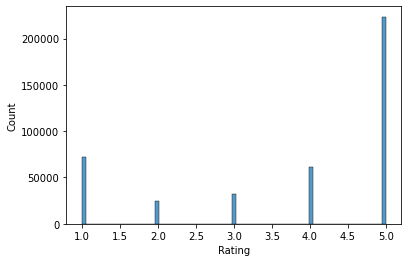

In [7]:
sns.histplot(data= df  ,x= 'Rating')

In [8]:
df.dropna(inplace=True)
df = df[df['Rating']!= 3]
df['sentiment'] = np.where(df['Rating']>3,1,0)
df

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,sentiment
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0,1
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0,1
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0,1
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0,1
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0,1
...,...,...,...,...,...,...,...
413832,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,4,good rugged phone that has a long-lasting batt...,0.0,1
413834,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,1,used hard,0.0,0
413835,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,5,another great deal great price,0.0,1
413837,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,5,Passes every drop test onto porcelain tile!,0.0,1


<AxesSubplot:xlabel='sentiment', ylabel='count'>

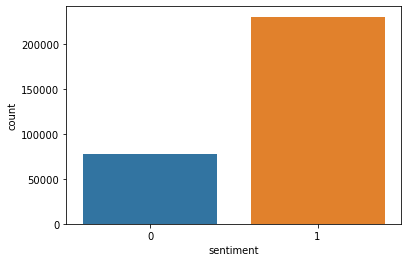

In [9]:
sns.countplot(data=df,x='sentiment')

In [10]:
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False,lemmatization=False):
    '''
    Convert a raw review to a cleaned review
    '''
    text = BeautifulSoup(raw_text, 'html.parser').get_text()
    letters_only = re.sub("[^a-zA-Z]", " ", text)
    words = letters_only.lower().split() 
    
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if stemming==True:

        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
    
    if lemmatization == True:
        lemmer = WordNetLemmatizer()
        words = [lemmer.lemmatize(w) for w in words ]
        
    if split_text==True:
        return (words)
    
    return( " ".join(words))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df['Reviews'], df['sentiment'],test_size=0.25, random_state=0)
                                                    
print('Number of Training examples\n', X_train.shape[0])
print('Number of Testing Examples\n', X_test.shape[0])
print('Review Example \n', X_train.iloc[0])

X_train_cleaned = []
X_test_cleaned = []

for d in X_train:
    X_train_cleaned.append(cleanText(d))
print('Cleaned review in the training set : \n',  X_train_cleaned[15])
    
for d in X_test:
    X_test_cleaned.append(cleanText(d))
print('Cleaned review in the training set : \n',  X_test_cleaned[15])

Number of Training examples
 231207
Number of Testing Examples
 77070
Review Example 
 I bought a BB Black and was deliveried a White BB.Really is not a serious provider...Next time is better to cancel the order.
Cleaned review in the training set : 
 love the color and the polka dot design the navy blue is what is pictured dark blue the polka dot design is not a film it is part of the backing it is not a fake otter box like a couple of reviews i read it came in its original packing it was a bit bulky at first but i got use to it it has three pieces the holster plastic casing with clear screen protector and rubber casing fyi clean your screen really well before putting on the plastic casing and make sure there is no lint on your screen or the clear screen protector seems like i will be taking it out of the case to clean the screen over time somehow lint and dust get in it otherwise just love the case and i feel like it will protect my phone knock on wood i haven t dropped my phone yet 

In [12]:
print("Un-cleaned text : \n",X_train[0])
print("\ncleaned text : \n",cleanText(X_train[0]))
print("\ncleaned text by removing stop words : \n",cleanText(X_train[0],remove_stopwords=True))
print("\ncleaned text by lemmatization       : \n",cleanText(X_train[0],remove_stopwords=True,lemmatization=True))

Un-cleaned text : 
 I feel so LUCKY to have found this used (phone to us & not used hard at all), phone on line from someone who upgraded and sold this one. My Son liked his old one that finally fell apart after 2.5+ years and didn't want an upgrade!! Thank you Seller, we really appreciate it & your honesty re: said used phone.I recommend this seller very highly & would but from them again!!

cleaned text : 
 i feel so lucky to have found this used phone to us not used hard at all phone on line from someone who upgraded and sold this one my son liked his old one that finally fell apart after years and didn t want an upgrade thank you seller we really appreciate it your honesty re said used phone i recommend this seller very highly would but from them again

cleaned text by removing stop words : 
 feel lucky found used phone us used hard phone line someone upgraded sold one son liked old one finally fell apart years want upgrade thank seller really appreciate honesty said used phone rec

# Model Building 

In [13]:
#CountVectorizer
countVect = CountVectorizer() 
X_train_countVect = countVect.fit_transform(X_train_cleaned)

#TfidfVectorizer
tfidfvectcount = TfidfVectorizer(min_df=5)
X_train_tfidfvectcount = tfidfvectcount.fit_transform(X_train_cleaned)



print("Number of features with countvectorizer : %d \n" %len(countVect.get_feature_names()))
print("Number of features with tfidfvectorizer : %d \n" %len(tfidfvectcount.get_feature_names()))
#print("Show some feature names : \n", countVect.get_feature_names()[::100])



Number of features with countvectorizer : 47469 

Number of features with tfidfvectorizer : 16710 



# 1) Logistic Regression 

In [14]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [15]:
tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
X_train_tfidf = tfidf.fit_transform(X_train)
print("Number of features : %d \n" %len(tfidf.get_feature_names())) 

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

Number of features : 17951 



LogisticRegression()


Accuracy on test set: 0.9481

AUC score : 0.9254

Classification report : 
               precision    recall  f1-score   support

           0       0.91      0.88      0.90     19500
           1       0.96      0.97      0.97     57570

    accuracy                           0.95     77070
   macro avg       0.94      0.93      0.93     77070
weighted avg       0.95      0.95      0.95     77070


Confusion Matrix : 
 [[17147  2353]
 [ 1645 55925]]


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

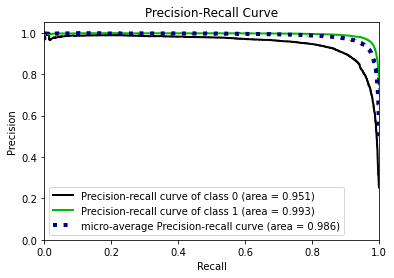

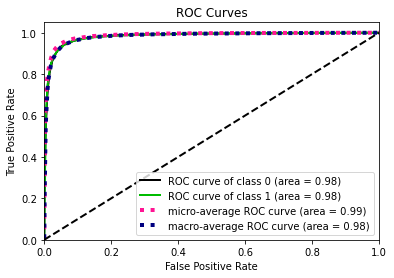

In [17]:
predictions1 = lr.predict(tfidf.transform(X_test_cleaned))
print ("\nAccuracy on test set: {:.4f}".format(accuracy_score(y_test, predictions1)))
print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions1)))
print("\nClassification report : \n", metrics.classification_report(y_test, predictions1))
print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictions1))



yhat1 = lr.predict_proba(tfidf.transform(X_test_cleaned))
skplt.metrics.plot_precision_recall(y_test,yhat1)
skplt.metrics.plot_roc_curve(y_test,yhat1)